<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [67]:
#импорт нужных библиотек
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import math

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    roc_curve,
    accuracy_score,
    mean_absolute_error
)

from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier


In [2]:
#загрузим данные
data = pd.read_csv('/datasets/Churn.csv')
data.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
#посмотрим внимательнее на наши данные
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
#найдём количество дубликатов в наших данных
print(data.duplicated().sum())

0


Видно, что есть пропуски в столбце Tenure. Количество этих пропусков относительно невелико (примерно 10%), поэтому можем просто удалить строки с этими пропусками. Дубликатов в нащих данных нет.

In [5]:
#удалим строки с пропусками
data_nn = data.dropna(subset=['Tenure'], axis=0)
print(data_nn.isnull().sum())

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


Если мы посмотрим на наши данные, то явно столбцы RowNumber (индекс строки в данных), CustomerId (уникальный номер) и Surname (фамилия человека) не будут влиять ни на что, поэтому их нужно удалить.

In [6]:
data_nn = data_nn.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

В данных у нас осталось 2 признака Geography (страна проживания) и Gender (пол), которые типа object. Здесь надо использовать OneHot encoding.

In [7]:
data_nn = pd.get_dummies(data_nn, columns=['Geography', 'Gender'], drop_first=True)

In [8]:
data_nn.head(5)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


Все типы признаков обработаны, отброшены столбцы, которые ни на что не будут влиять, использован метод OneHot Encoding.

In [9]:
data_nn.corr()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
CreditScore,1.000000,-0.004504,-0.000062,0.002804,0.011090,-0.003937,0.030947,0.005182,-0.023950,0.000428,0.001725,-0.008547
Age,-0.004504,1.000000,-0.013134,0.031481,-0.031877,-0.014129,0.082269,-0.007037,0.283017,0.049038,-0.005622,-0.025631
Tenure,-0.000062,-0.013134,1.000000,-0.007911,0.011979,0.027232,-0.032178,0.010520,-0.016761,-0.003299,0.000810,0.012634
Balance,0.002804,0.031481,-0.007911,1.000000,-0.301858,-0.019055,-0.003285,0.014351,0.117218,0.401701,-0.136986,0.018030
NumOfProducts,0.011090,-0.031877,0.011979,-0.301858,1.000000,0.005805,0.009084,0.013990,-0.050271,-0.009476,0.011903,-0.025176
HasCrCard,-0.003937,-0.014129,0.027232,-0.019055,0.005805,1.000000,-0.008810,-0.006136,-0.005411,0.009149,-0.017779,0.006016
IsActiveMember,0.030947,0.082269,-0.032178,-0.003285,0.009084,-0.008810,1.000000,-0.020049,-0.155062,-0.016821,0.014800,0.025019
EstimatedSalary,0.005182,-0.007037,0.010520,0.014351,0.013990,-0.006136,-0.020049,1.000000,0.016029,0.011551,-0.010998,-0.002658
Exited,-0.023950,0.283017,-0.016761,0.117218,-0.050271,-0.005411,-0.155062,0.016029,1.000000,0.178131,-0.055971,-0.110450
Geography_Germany,0.000428,0.049038,-0.003299,0.401701,-0.009476,0.009149,-0.016821,0.011551,0.178131,1.000000,-0.332879,-0.023701


## Исследование задачи

Разделим данные на тренировочные и валидационные.

In [10]:
target = data_nn['Exited']
features = data_nn.drop('Exited', axis=1)

In [11]:
features_train, features_valid_test, target_train, target_valid_test = train_test_split(
    features, target, test_size=0.4, random_state=12345)

features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid_test, target_valid_test, test_size=0.5, random_state=12345)

In [12]:
features_valid.shape

(1818, 11)

In [13]:
features_valid_test.shape

(3637, 11)

In [14]:
target_valid.shape

(1818,)

In [15]:
data_nn.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
count,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000
mean,650.736553,38.949181,4.997690,76522.740015,1.530195,0.704983,0.515565,100181.214924,0.203938,0.252227,0.247278,0.547135
std,96.410471,10.555581,2.894723,62329.528576,0.581003,0.456076,0.499785,57624.755647,0.402946,0.434315,0.431453,0.497801
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000,0.000000,0.000000,0.000000
25%,584.000000,32.000000,2.000000,0.000000,1.000000,0.000000,0.000000,51227.745000,0.000000,0.000000,0.000000,0.000000
50%,652.000000,37.000000,5.000000,97318.250000,1.000000,1.000000,1.000000,100240.200000,0.000000,0.000000,0.000000,1.000000
75%,717.000000,44.000000,7.000000,127561.890000,2.000000,1.000000,1.000000,149567.210000,0.000000,1.000000,0.000000,1.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000,1.000000,1.000000,1.000000


In [16]:
#выделим признаки, которые нужно масштабировать
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary', 'NumOfProducts']

In [17]:
#добавим, чтобы не было ошибки
pd.options.mode.chained_assignment = None

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [18]:
#теперь проверим на сбалинсированность 2 класса в target
class_rate = list(data_nn['Exited'].value_counts(normalize=True))
print(class_rate)

[0.7960620393796062, 0.2039379606203938]


Мы видим, что имеется явный дисбаланс в сторону 0 класса. Его значений примерно в 4 раза больше, чем другого класса.

Исследуем модели без учёта дисбаланса классов.

**Logistic Regression**

In [19]:
model_lr = LogisticRegression(random_state=12345, solver='liblinear')
model_lr.fit(features_train, target_train)

predicted_valid_lr = model_lr.predict(features_valid)

In [20]:
probabilities_valid_lr = model_lr.predict_proba(features_valid)
probabilities_one_valid_lr = probabilities_valid_lr[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid_lr)

In [21]:
print('Для валидационной выборки')
print('F1:', f1_score(target_valid, predicted_valid_lr))
print('Accuracy:', accuracy_score(predicted_valid_lr, target_valid))
print('AUC_ROC:', auc_roc)

Для валидационной выборки
F1: 0.30400000000000005
Accuracy: 0.8085808580858086
AUC_ROC: 0.7736191158144302


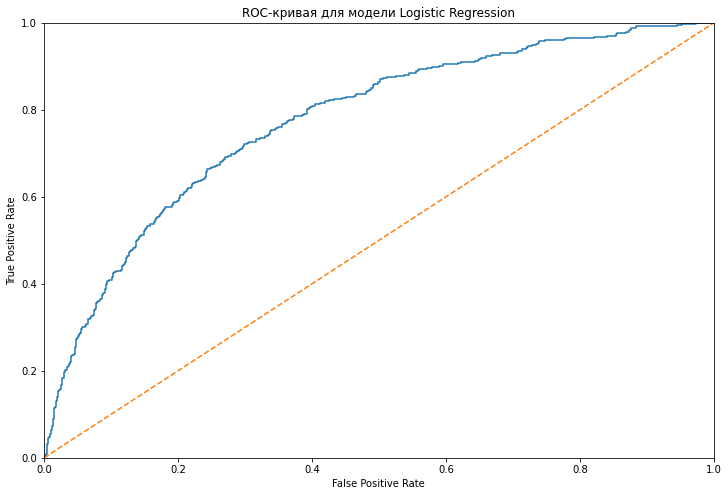

In [22]:
#построим кривую ROC
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid_lr) 
plt.figure(figsize=(12,8))

plt.plot(fpr, tpr)
# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC-кривая для модели Logistic Regression')
plt.show()

**Random Forest**

In [23]:
best_score = 0

for n_est in tqdm(range(10, 101, 10)):
    for depth in range(1, 21):
        model_rf = RandomForestClassifier(
            n_estimators=n_est, max_depth=depth, random_state=12345)
        model_rf.fit(features_train, target_train)
        predicted_valid_rf = model_rf.predict(features_valid)
        probabilities_valid_rf = model_rf.predict_proba(features_valid)
        probabilities_one_valid_rf = probabilities_valid_rf[:, 1]
        
        score = model_rf.score(features_valid, target_valid)
        score_f1 = f1_score(target_valid, predicted_valid_rf)
        auc_roc = roc_auc_score(target_valid, probabilities_one_valid_rf)
        
        if score_f1 > best_score:
            best_model_rf = model_rf
            best_score = score_f1
            best_depth = depth
            best_n_est = n_est
            best_accuracy = score
            best_auc_roc = auc_roc
        
print('Лучшая глубина:', best_depth, 'Лучшее количество деревьев:', n_est)
print('F1:', best_score)
print('Accuracy:', best_accuracy)
print('AUC ROC:', best_auc_roc)

100%|██████████| 10/10 [01:07<00:00,  6.75s/it]

Лучшая глубина: 17 Лучшее количество деревьев: 100
F1: 0.5986842105263158
Accuracy: 0.8657865786578658
AUC ROC: 0.8632764971275104


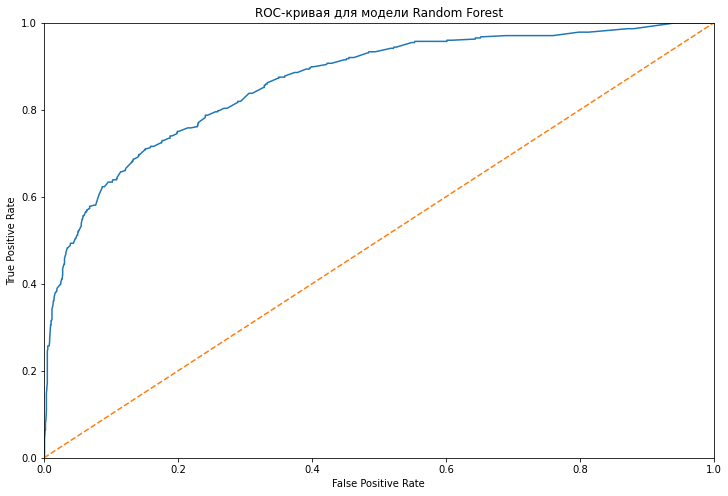

In [24]:
#построим кривую ROC
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid_rf) 
plt.figure(figsize=(12,8))

plt.plot(fpr, tpr)
# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC-кривая для модели Random Forest')
plt.show()

**Decision Tree**

In [26]:
best_score = 0

for depth in range(1, 51):
    for cri in ['entropy', 'gini']:
        model_dt = DecisionTreeClassifier(
            max_depth=depth, criterion=cri)
        
        model_dt.fit(features_train, target_train)
        predicted_valid_dt = model_dt.predict(features_valid)
        probabilities_valid_dt = model_dt.predict_proba(features_valid)
        probabilities_one_valid_dt = probabilities_valid_dt[:, 1]
        
        score = model_dt.score(features_valid, target_valid)
        score_f1 = f1_score(target_valid, predicted_valid_dt)
        auc_roc = roc_auc_score(target_valid, probabilities_one_valid_dt)
        
        if score_f1 > best_score:
            best_model_dt = model_dt
            best_score = score_f1
            best_depth = depth
            best_criterion = cri
            best_accuracy = score
            best_auc_roc = auc_roc

print('Лучшая глубина:', best_depth, 'Лучший критерий:', best_criterion)
print('F1:', best_score)
print('Accuracy:', best_accuracy)
print('AUC ROC:', best_auc_roc)        

Лучшая глубина: 6 Лучший критерий: entropy
F1: 0.5785953177257526
Accuracy: 0.8613861386138614
AUC ROC: 0.8424438157262585


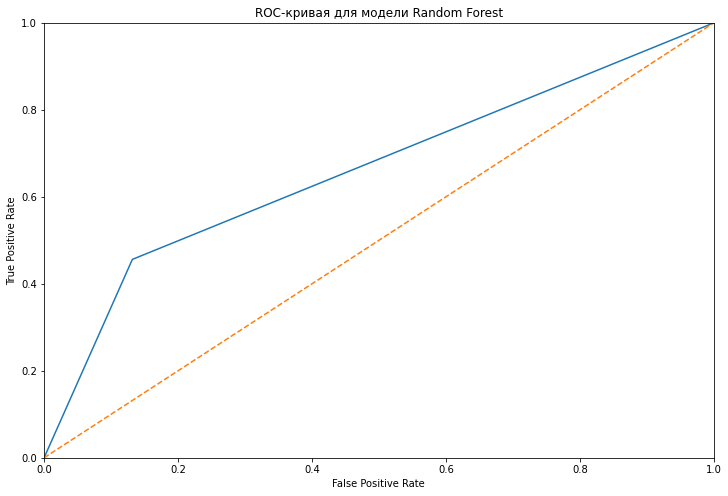

In [27]:
#построим кривую ROC
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid_dt) 
plt.figure(figsize=(12,8))

plt.plot(fpr, tpr)
# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC-кривая для модели Random Forest')
plt.show()

Без учёта дисбаланса классов были обучены 3 модели Logistic regression, Random forest и Decision Tree. Наилучшее значение метрики F1 достигается для Random Forest (0.60, лучшая точность также у модели Random Forest (0.87), как и значение AUC ROC: 0.86. Все эти значения получены на валидационной выборке.

Значения всех этих параметров на тестовой выборке получились ниже, чем на валидационной. Лучшие результаты вновь достигаются на модели Random Forest.

Наилучшие значения параметров модели Random Forest: наилучшая глубина = 17, наилучшее количество деревьев = 100.

## Борьба с дисбалансом

Существует 2 пути решения проблемы с дисбалансом классов:
* upsampling
* downsampling

**Upsampling**

In [28]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [29]:
features_train_upsampled, target_train_upsampled = upsample(
    features_train, target_train, math.ceil(class_rate[0]/class_rate[1]))

**Logistic Regression**

In [30]:
model_lr_up = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model_lr_up.fit(features_train_upsampled, target_train_upsampled)
predicted_valid_lr_up = model_lr_up.predict(features_valid)

probabilities_valid_lr_up = model_lr_up.predict_proba(features_valid)
probabilities_one_valid_lr_up = probabilities_valid_lr_up[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid_lr_up)

In [31]:
print('Для валидационной выборки')
print('F1:', f1_score(target_valid, predicted_valid_lr_up))
print('Accuracy:', accuracy_score(predicted_valid_lr_up, target_valid))
print('AUC_ROC:', auc_roc)

Для валидационной выборки
F1: 0.509731232622799
Accuracy: 0.7090209020902091
AUC_ROC: 0.7777552797294834


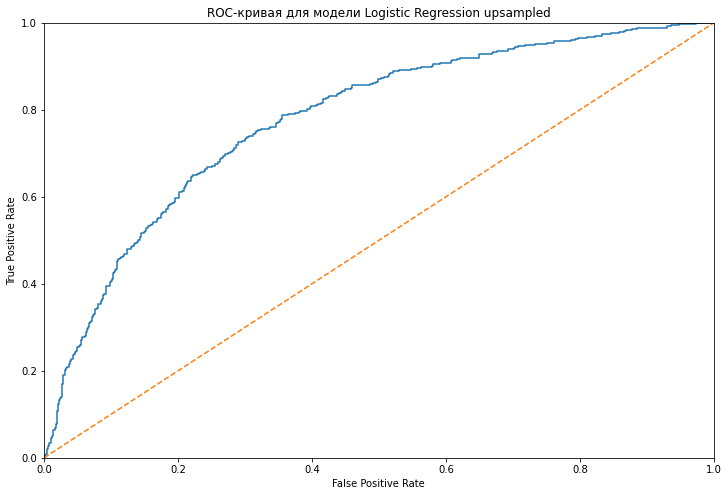

In [32]:
#построим кривую ROC
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid_lr_up) 
plt.figure(figsize=(12,8))

plt.plot(fpr, tpr)
# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC-кривая для модели Logistic Regression upsampled')
plt.show()

**Random Forest**

In [33]:
best_score = 0

for n_est in tqdm(range(10, 101, 10)):
    for depth in range(1, 21):
        model_rf = RandomForestClassifier(
            n_estimators=n_est, max_depth=depth, random_state=12345)
        model_rf.fit(features_train_upsampled, target_train_upsampled)
        predicted_valid_rf_up = model_rf.predict(features_valid)
        probabilities_valid_rf_up = model_rf.predict_proba(features_valid)
        probabilities_one_valid_rf_up = probabilities_valid_rf_up[:, 1]
        
        score = model_rf.score(features_valid, target_valid)
        score_f1 = f1_score(target_valid, predicted_valid_rf_up)
        auc_roc = roc_auc_score(target_valid, probabilities_one_valid_rf_up)
        
        if score_f1 > best_score:
            best_model_rf_up = model_rf
            best_score = score_f1
            best_depth = depth
            best_n_est = n_est
            best_accuracy = score
            best_auc_roc = auc_roc
        
print('Лучшая глубина:', best_depth, 'Лучшее количество деревьев:', n_est)
print('F1:', best_score)
print('Accuracy:', best_accuracy)
print('AUC ROC:', best_auc_roc)

100%|██████████| 10/10 [01:28<00:00,  8.90s/it]

Лучшая глубина: 14 Лучшее количество деревьев: 100
F1: 0.6395663956639566
Accuracy: 0.8536853685368537
AUC ROC: 0.8614035346070091


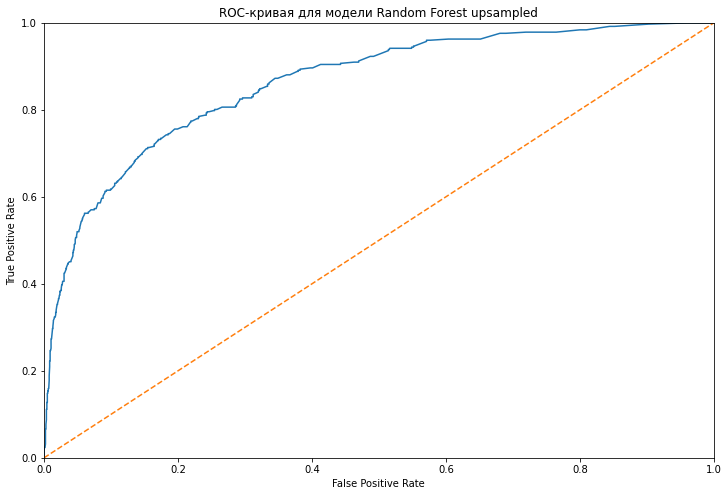

In [34]:
#построим кривую ROC
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid_rf_up) 
plt.figure(figsize=(12,8))

plt.plot(fpr, tpr)
# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC-кривая для модели Random Forest upsampled')
plt.show()

**Decision Tree**

In [36]:
best_score = 0

for depth in range(1, 51):
    for cri in ['entropy', 'gini']:
        model_dt = DecisionTreeClassifier(
            max_depth=depth, criterion=cri)
        
        model_dt.fit(features_train_upsampled, target_train_upsampled)
        predicted_valid_dt_up = model_dt.predict(features_valid)
        probabilities_valid_dt_up = model_dt.predict_proba(features_valid)
        probabilities_one_valid_dt_up = probabilities_valid_dt_up[:, 1]
        
        score = model_dt.score(features_valid, target_valid)
        score_f1 = f1_score(target_valid, predicted_valid_dt_up)
        auc_roc = roc_auc_score(target_valid, probabilities_one_valid_dt_up)
        
        if score_f1 > best_score:
            best_model_dt_up = model_dt
            best_score = score_f1
            best_depth = depth
            best_criterion = cri
            best_accuracy = score
            best_auc_roc = auc_roc

print('Лучшая глубина:', best_depth, 'Лучший критерий:', best_criterion)
print('F1:', best_score)
print('Accuracy:', best_accuracy)
print('AUC ROC:', best_auc_roc)  

Лучшая глубина: 5 Лучший критерий: gini
F1: 0.5735449735449736
Accuracy: 0.7783278327832783
AUC ROC: 0.8396523192522141


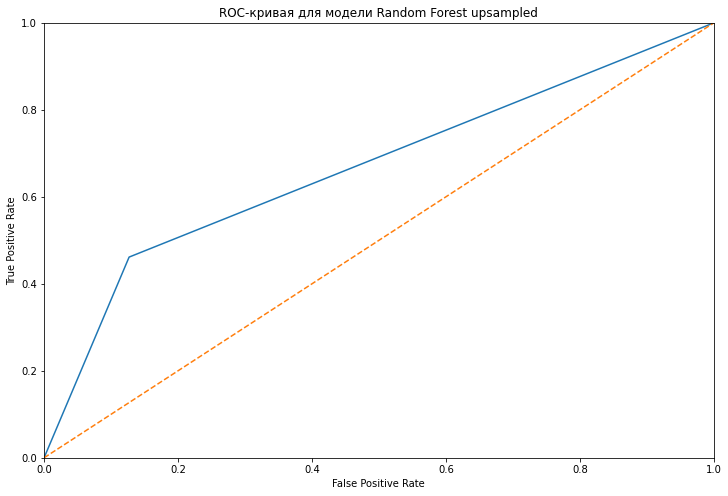

In [37]:
#построим кривую ROC
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid_dt_up) 
plt.figure(figsize=(12,8))

plt.plot(fpr, tpr)
# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC-кривая для модели Random Forest upsampled')
plt.show()

**Downsampling**

In [38]:
def downsample(features, target, fraction):
    
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=13245)]
        + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)]
        + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [39]:
features_train_downsampled, target_train_downsampled = downsample(
    features_train, target_train, class_rate[1]/class_rate[0])

**Logistic Regression**

In [40]:
model_lr_down = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model_lr_down.fit(features_train_downsampled, target_train_downsampled)
predicted_valid_lr_down = model_lr_down.predict(features_valid)

probabilities_valid_lr_down = model_lr_down.predict_proba(features_valid)
probabilities_one_valid_lr_down = probabilities_valid_lr_down[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid_lr_down)

In [41]:
print('Для валидационной выборки')
print('F1:', f1_score(target_valid, predicted_valid_lr_down))
print('Accuracy:', accuracy_score(predicted_valid_lr_down, target_valid))
print('AUC_ROC:', auc_roc)

Для валидационной выборки
F1: 0.5050691244239632
Accuracy: 0.7046204620462047
AUC_ROC: 0.7811901181208893


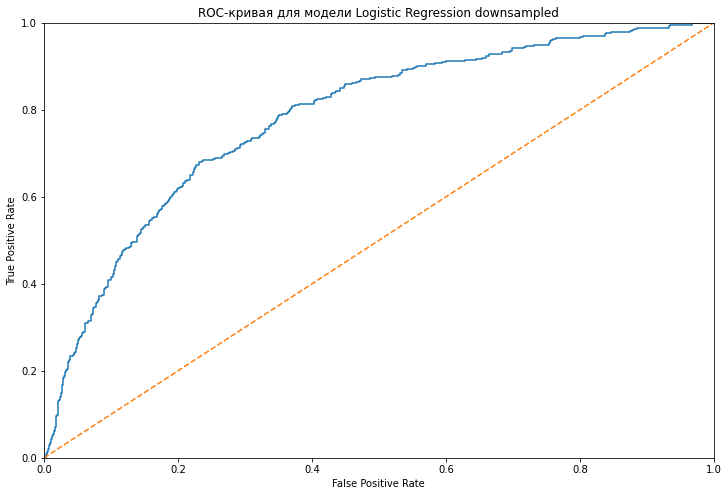

In [42]:
#построим кривую ROC
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid_lr_down) 
plt.figure(figsize=(12,8))

plt.plot(fpr, tpr)
# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC-кривая для модели Logistic Regression downsampled')
plt.show()

**Random Forest**

In [43]:
best_score = 0

for n_est in tqdm(range(10, 101, 10)):
    for depth in range(1, 21):
        model_rf = RandomForestClassifier(
            n_estimators=n_est, max_depth=depth, random_state=12345)
        model_rf.fit(features_train_downsampled, target_train_downsampled)
        predicted_valid_rf_down = model_rf.predict(features_valid)
        probabilities_valid_rf_down = model_rf.predict_proba(features_valid)
        probabilities_one_valid_rf_down = probabilities_valid_rf_down[:, 1]
        
        score = model_rf.score(features_valid, target_valid)
        score_f1 = f1_score(target_valid, predicted_valid_rf_down)
        auc_roc = roc_auc_score(target_valid, probabilities_one_valid_rf_down)
        
        if score_f1 > best_score:
            best_model_rf_down = model_rf
            best_score = score_f1
            best_depth = depth
            best_n_est = n_est
            best_accuracy = score
            best_auc_roc = auc_roc
        
print('Лучшая глубина:', best_depth, 'Лучшее количество деревьев:', n_est)
print('F1:', best_score)
print('Accuracy:', best_accuracy)
print('AUC ROC:', best_auc_roc)

100%|██████████| 10/10 [00:44<00:00,  4.44s/it]

Лучшая глубина: 10 Лучшее количество деревьев: 100
F1: 0.6077235772357724
Accuracy: 0.7876787678767877
AUC ROC: 0.8661535884489293


<div class="alert alert-warning">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b> 

И здесь почему-то вернулись к score. Оптимизироваться нужно по f1-мере.
       
</div>


<font color='blue'>Исправила</font>

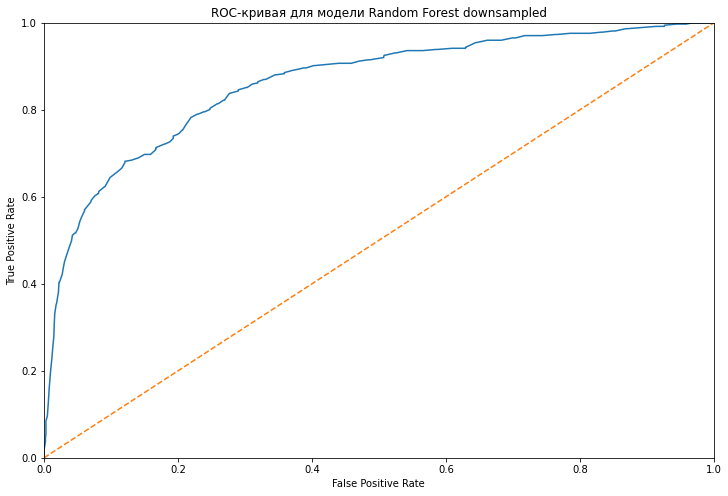

In [44]:
#построим кривую ROC
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid_rf_down) 
plt.figure(figsize=(12,8))

plt.plot(fpr, tpr)
# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC-кривая для модели Random Forest downsampled')
plt.show()

**Decision Tree**

In [45]:
best_score = 0

for depth in range(1, 51):
    for cri in ['entropy', 'gini']:
        model_dt = DecisionTreeClassifier(
            max_depth=depth, criterion=cri)
        
        model_dt.fit(features_train_downsampled, target_train_downsampled)
        predicted_valid_dt_down = model_dt.predict(features_valid)
        probabilities_valid_dt_down = model_dt.predict_proba(features_valid)
        probabilities_one_valid_dt_down = probabilities_valid_dt_down[:, 1]
        
        score = model_dt.score(features_valid, target_valid)
        score_f1 = f1_score(target_valid, predicted_valid_dt_down)
        auc_roc = roc_auc_score(target_valid, probabilities_one_valid_dt_down)
        
        if score_f1 > best_score:
            best_model_dt_down = model_dt
            best_score = score_f1
            best_depth = depth
            best_criterion = cri
            best_accuracy = score
            best_auc_roc = auc_roc

print('Лучшая глубина:', best_depth, 'Лучший критерий:', best_criterion)
print('F1:', best_score)
print('Accuracy:', best_accuracy)
print('AUC ROC:', best_auc_roc)  

Лучшая глубина: 5 Лучший критерий: entropy
F1: 0.585792349726776
Accuracy: 0.7915291529152916
AUC ROC: 0.8367522185632216


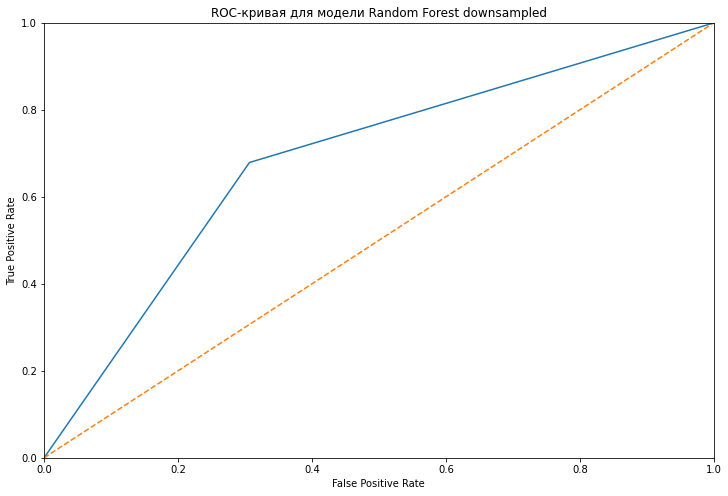

In [46]:
#построим кривую ROC
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid_dt_down) 
plt.figure(figsize=(12,8))

plt.plot(fpr, tpr)
# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC-кривая для модели Random Forest downsampled')
plt.show()

Посмотрим, как изменились метрики качества моделей при обучении на измененной обучающей выборке: upsampling и downsampling.

1. Logisctic Regression

    Максимальная accuracy (0.71) достигается на изначальных тренировочных данных данных, без использования техник upsampling и downsampling. Аналогично для показателя F1 максимальное значение (0.51) находится на данных без учёта дисбаланса классов.


2. Random Forest

    Для этой модели на всех данных с учётом и без учета дисбаланса классов метрика F1 больше 0.59. Но максимальное значение этой метрики мы находим на данных, подготовленных техникой upsampling (0.64). Метрики accuracy и auc roc максимальны для данных без учёта дисбаланса 0.87 и 0.86, соответственно.


3. Decision Tree

    Лучший показатель метрики F1 для этой модели равен 0.59, когда мы использовали технику downsampling для тренировочных данных. Лучшая метрика auc roc (0.84) также достигается на downsampling данных, а наилучшее значение accuracy (0.86) достигается без учёта несбалансированности классов.
    

## Тестирование модели

Протестируем наилучшую модель с наибольшей метрикой F1. Это модель Random Forest с максимальной глубиной, равной 19, и количеством деревьев 100 на upsampling данных.

In [48]:
#для тестовой выборки
predicted_test_rf_up = best_model_rf_up.predict(features_test)
probabilities_test_rf_up = best_model_rf_up.predict_proba(features_test)
probabilities_one_test_rf_up = probabilities_test_rf_up[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test_rf_up)

In [49]:
print('Для тестовой выборки')
print('F1:', f1_score(target_test, predicted_test_rf_up))
print('Accuracy:', accuracy_score(predicted_test_rf_up, target_test))
print('AUC_ROC:', auc_roc)

Для тестовой выборки
F1: 0.5988538681948424
Accuracy: 0.8460692688290269
AUC_ROC: 0.8522380586413283


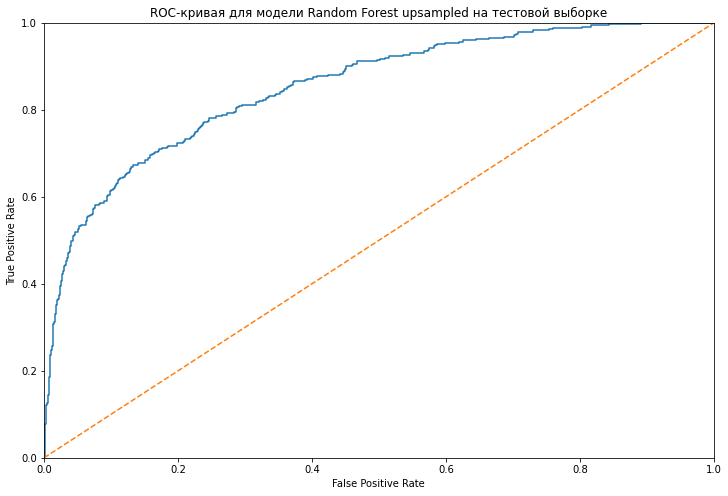

In [50]:
#построим кривую ROC
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test_rf_up) 
plt.figure(figsize=(12,8))

plt.plot(fpr, tpr)
# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC-кривая для модели Random Forest upsampled на тестовой выборке')
plt.show()

На тестовых данных удалось достичь значения F1 > 0.59. Значение метрики auc roc равно 0.85, оно получилось немного меньше, чем на валидационных данных (0.86).

Теперь сравним нашу лучшую модель с константной моделью по метрике F1.

In [53]:
dummy_model = DummyClassifier(strategy='constant', constant=1)
dummy_model.fit(features_train, target_train)
score_f1_dummy = f1_score(dummy_model.predict(features_test), target_test)
print('F1:', score_f1_dummy)

F1: 0.3235023041474654


Как видим, наша модель имеет показатель F1 почти в 2 раза больше, чем у константной модели. Успех!

## Вывод

В ходе наших исследований был проведён анализ трёх моделей: дерево решений, случайный лес и логистическая регрессия на разных обучающих выборках. 

На первом этапе при обучении моделей мы не учитывали существующий дисбаланс классов, где лучший результат метрики F1 (0.59) и auc roc (0.86) показала модель Random Forest. 

На следующем шаге мы использовали 2 техники для работы с данными, в которых присутствует дисбаланс классов: upsampling и downsampling. Как оказалось, для различных моделей эти техники работают в разной степени. Так для Random Forest с помощью техники upsampling было найдено наибольшее значение метрики F1, а для модели Decision Tree - наибольшее значение на downsampling данных.

Далее мы проверили нашу наилучшую модель Random Forest с максимальной глубиной, равной 19, и количеством деревьев 100, обученной на upsampled тренировочных данных, на тестовой части данных. В итоге, была получена метрика F1 > 0.59. Значение метрики auc roc для этой модели также достигает хорошего значения (0.85).

Дополнительно были построены графики ROC-кривых для разных моделей, обученных на сбалансированных и несбалансированных тренировочных данных. Также на первом этапе наших исследований наши модели были проверены натестовом наборе данных.